In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaydepaolomirandilla","key":"059e98513e292cf0cc5e7ac24b6c6d1c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jaydepaolomirandilla/philippinemedicinalplants

Dataset URL: https://www.kaggle.com/datasets/jaydepaolomirandilla/philippinemedicinalplants
License(s): apache-2.0
 69% 17.0M/24.6M [00:00<00:00, 61.0MB/s]
100% 24.6M/24.6M [00:00<00:00, 72.8MB/s]


In [ ]:
#!unzip -qq philippinemedicinalplants.zip

!unzip -qq english-philippine-medicinal-plants.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

data_dir = "/content/PhilippineMedicinalPlants/Philippine Medicinal Plant Leaf Dataset"
train_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="both", seed=123, image_size=(224, 224))
class_names = train_ds.class_names

data_augmentation = tf.keras.Sequential([
    #tf.keras.layers.RandomCrop(0.7, 0.7, seed=123),
    tf.keras.layers.RandomFlip(seed=123),
    tf.keras.layers.RandomTranslation(0.7, 0.7, seed=123),
    tf.keras.layers.RandomRotation(0.2, seed=123),
    tf.keras.layers.RandomZoom(0.2, seed=123),
    tf.keras.layers.RandomContrast(0.2, seed=123),
    tf.keras.layers.RandomBrightness(0.2, seed=123),
    #tf.keras.layers.RandomWidth(factor=0.2),
    #tf.keras.layers.RandomHeight(factor=0.2),
    ])

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(lambda img, label: (data_augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_ds.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_ds.prefetch(tf.data.AUTOTUNE)

Found 4971 files belonging to 40 classes.
Using 3977 files for training.
Using 994 files for validation.


In [ ]:
base_model = tf.keras.applications.EfficientNetB1(include_top=False, input_shape=(224, 224, 3))
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(units=40, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

checkpoint = ModelCheckpoint('efficientnetb1_10.keras', save_best_only=True)
earlystop = EarlyStopping(min_delta=0.001, patience=3, restore_best_weights=True)
csvlogger = CSVLogger(filename= "efficientnetb1_10.log")
reduceLR = ReduceLROnPlateau()
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=[callbacks])

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 579ms/step - accuracy: 0.0240 - loss: 3.7616 - val_accuracy: 0.0915 - val_loss: 3.4615 - learning_rate: 1.0000e-04
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 540ms/step - accuracy: 0.0814 - loss: 3.4770 - val_accuracy: 0.2243 - val_loss: 3.1775 - learning_rate: 1.0000e-04
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 526ms/step - accuracy: 0.1488 - loss: 3.3009 - val_accuracy: 0.3270 - val_loss: 2.9383 - learning_rate: 1.0000e-04
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 522ms/step - accuracy: 0.1982 - loss: 3.1351 - val_accuracy: 0.3974 - val_loss: 2.7366 - learning_rate: 1.0000e-04
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 533ms/step - accuracy: 0.2440 - loss: 3.0084 - val_accuracy: 0.4648 - val_loss: 2.5635 - learning_rate: 1.0000e-04
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 529ms/step - accuracy: 0.2681 - loss: 2.9001 - val_accuracy: 0.5332 - val_loss: 2.4066 - learning_rate: 1.0000

In [ ]:
_, baseline_model_accuracy = model.evaluate(validation_dataset)
print('Baseline accuracy:', baseline_model_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.6240 - loss: 1.9768
Baseline accuracy: 0.6448692083358765


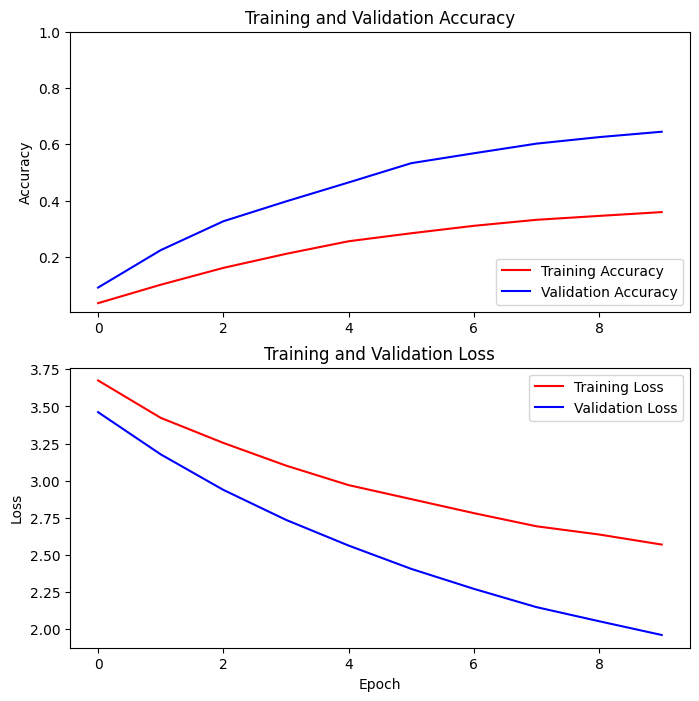

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
los = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(los, 'r', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim([0,1.0])
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.show()

In [ ]:
checkpoint1 = ModelCheckpoint('efficientnetb1_40.keras', save_best_only=True)
earlystop1 = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)
csvlogger1 = CSVLogger(filename= "efficientnetb1_40.log")
reduceLR1 = ReduceLROnPlateau()
callbacks_fine = [checkpoint1, earlystop1, csvlogger1, reduceLR1]

base_model.trainable = True
fine_tune_at = int(np.round(0.5*len(base_model.layers)))
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model_fine = tf.keras.Model(inputs, outputs)

model_fine.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_fine.fit(train_dataset, epochs=total_epochs, initial_epoch=initial_epochs, validation_data=validation_dataset, callbacks=[callbacks_fine])

Epoch 11/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 590ms/step - accuracy: 0.2734 - loss: 2.8697 - val_accuracy: 0.7153 - val_loss: 1.2720 - learning_rate: 1.0000e-04
Epoch 12/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 575ms/step - accuracy: 0.4655 - loss: 2.0020 - val_accuracy: 0.8682 - val_loss: 0.6090 - learning_rate: 1.0000e-04
Epoch 13/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.5776 - loss: 1.5868 - val_accuracy: 0.8652 - val_loss: 0.4944 - learning_rate: 1.0000e-04
Epoch 14/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.6371 - loss: 1.3810 - val_accuracy: 0.9014 - val_loss: 0.3969 - learning_rate: 1.0000e-04
Epoch 15/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 573ms/step - accuracy: 0.6664 - loss: 1.2106 - val_accuracy: 0.9245 - val_loss: 0.3057 - learning_rate: 1.0000e-04
Epoch 16/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 565ms/step - accuracy: 0.6947 - loss: 1.1250 - val_accuracy: 0.8964 - val_loss: 0.3394 - learning_rate: 1.0000e-04
Epoch 17/40
125/125 ━━━━━━━━━━━━━━━━━━━

In [ ]:
_, baseline_model_fine_accuracy = model_fine.evaluate(validation_dataset)
print('Baseline accuracy:', baseline_model_fine_accuracy)

In [ ]:
acc1 = history_fine.history['accuracy']
val_acc1 = history_fine.history['val_accuracy']
los1 = history_fine.history['loss']
val_loss1 = history_fine.history['val_loss']

acc_fine = acc + acc1
val_acc_fine = val_acc + val_acc1
los_fine = los + los1
val_loss_fine = val_loss + val_loss1

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc_fine, 'r', label='Training Accuracy')
plt.plot(val_acc_fine, 'b', label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.xlim([0, total_epochs])
plt.plot([initial_epochs,initial_epochs], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(los_fine, 'r', label='Training Loss')
plt.plot(val_loss_fine, 'b', label='Validation Loss')
#plt.ylim([0, 1.0])
plt.xlim([0, total_epochs])
plt.plot([initial_epochs,initial_epochs], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step


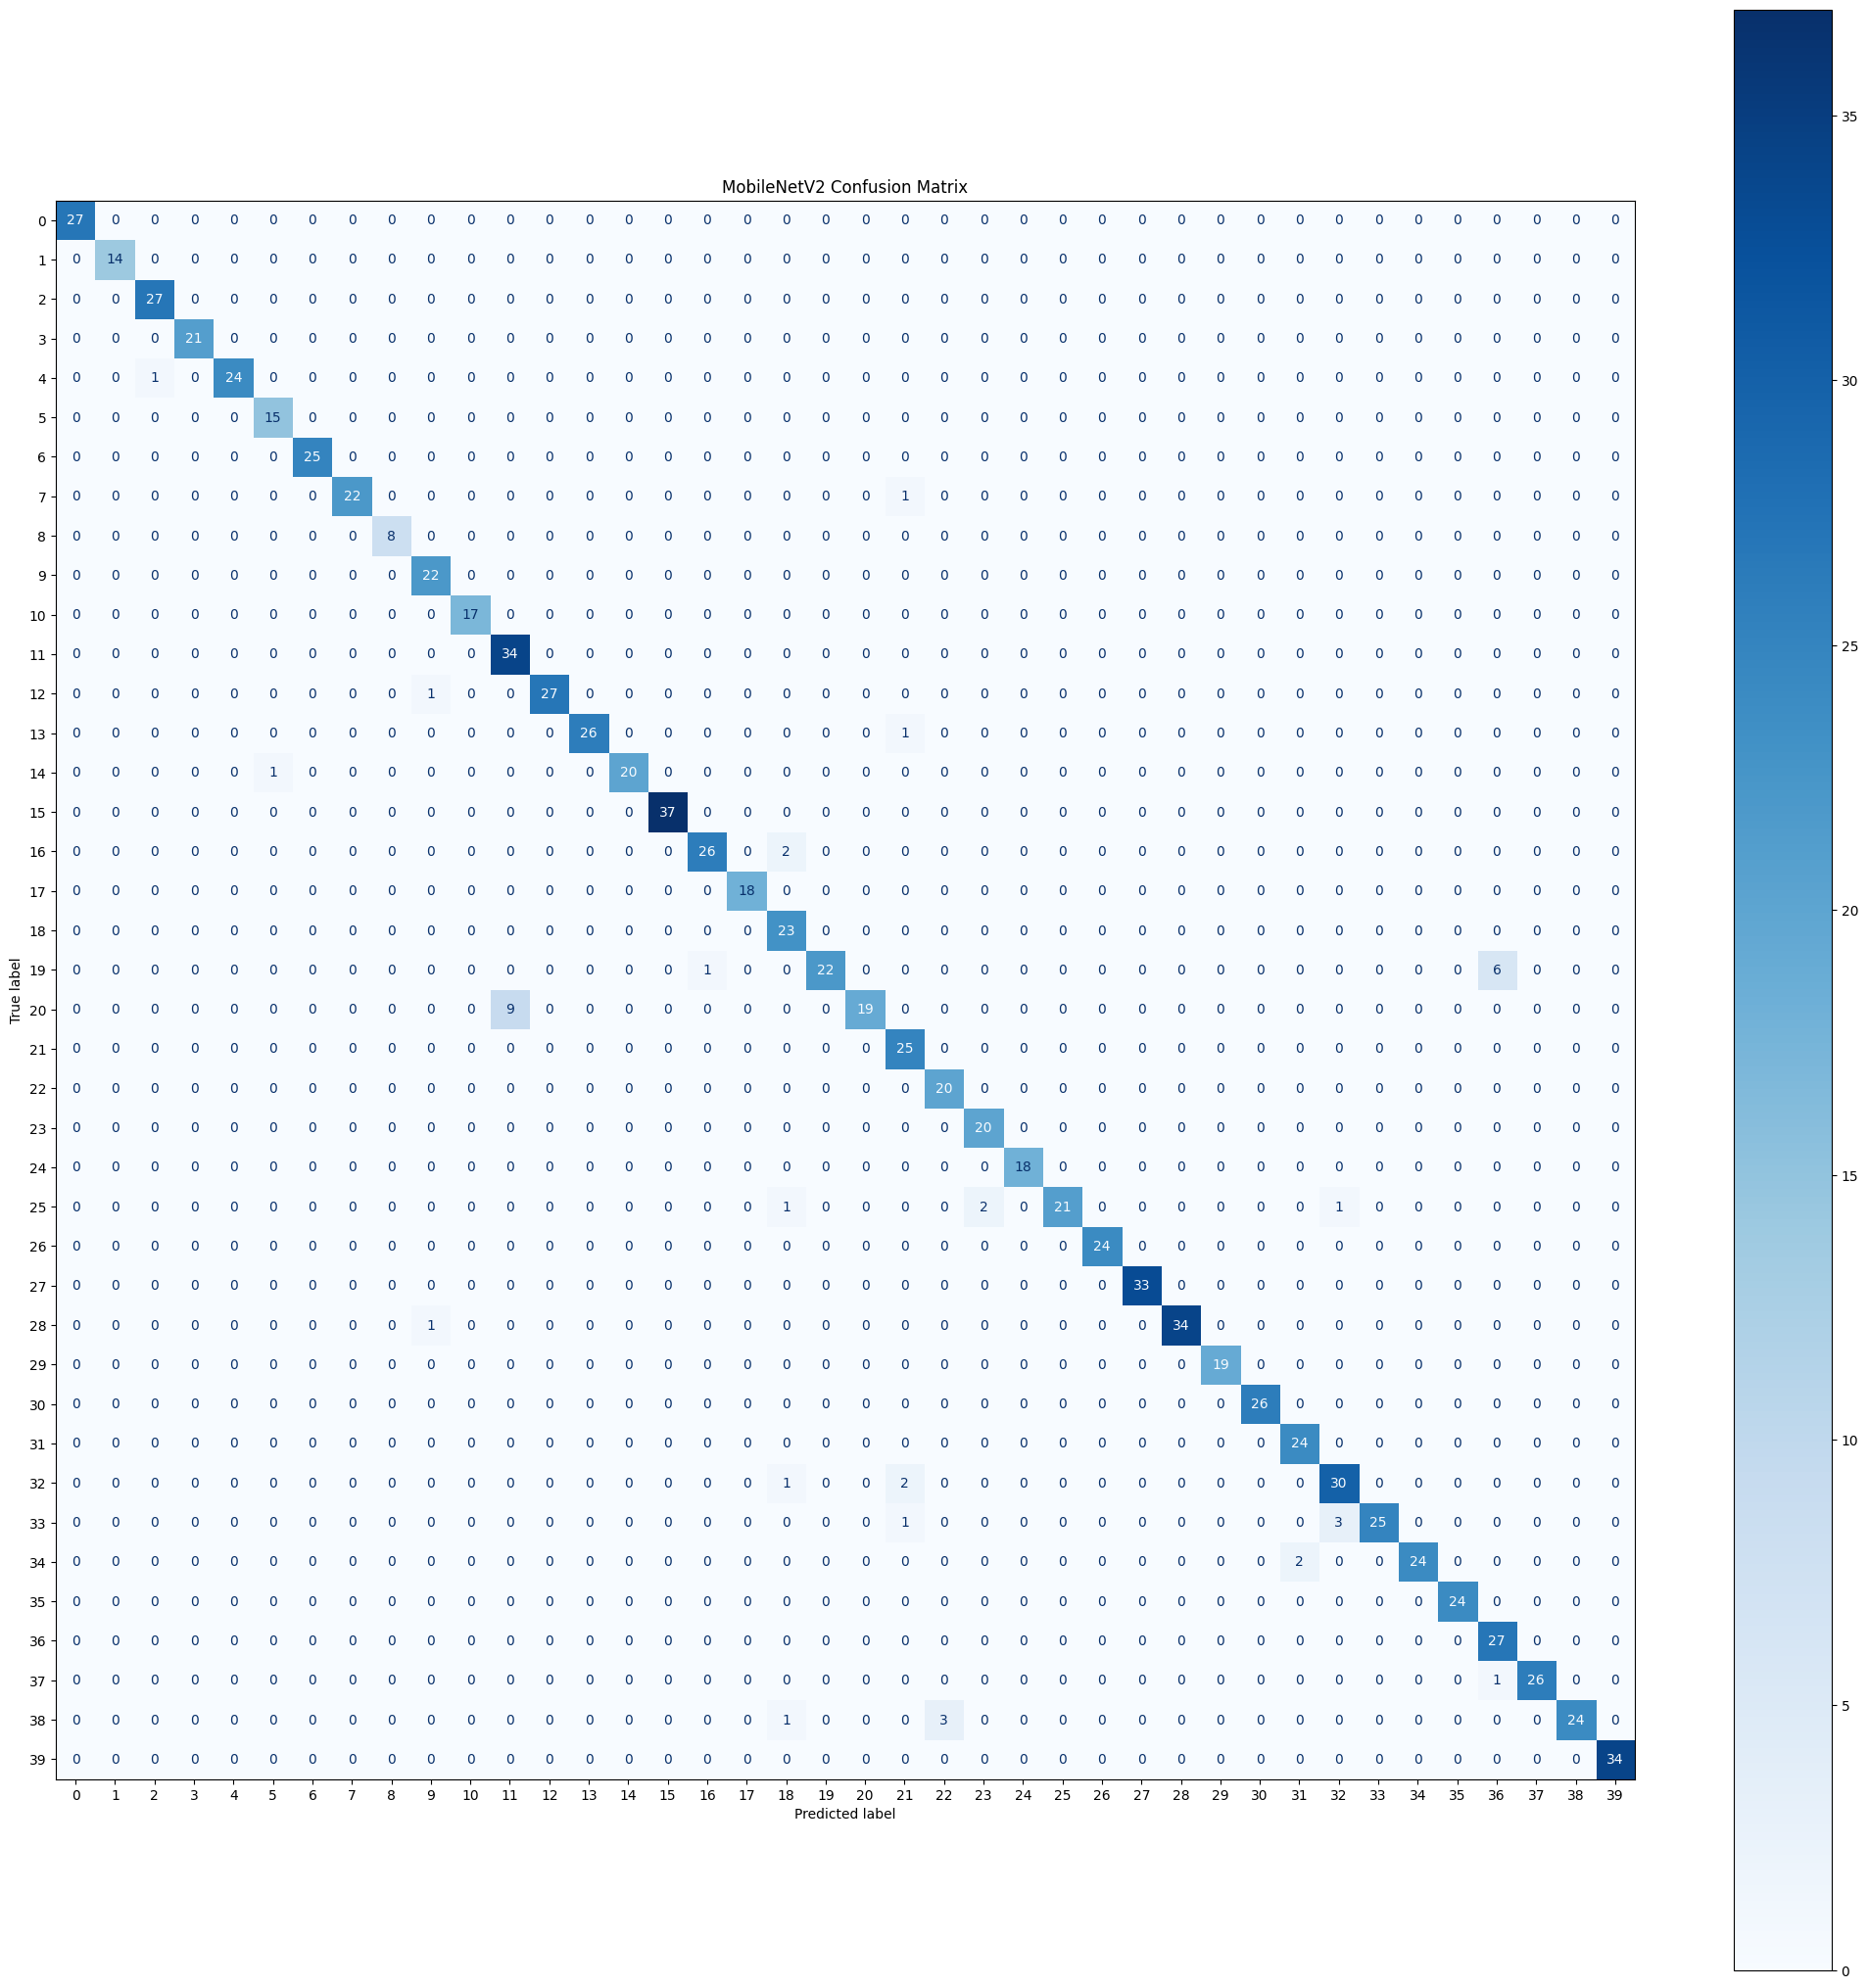

In [ ]:
#Predict
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

mobilenetv2 = tf.keras.models.load_model('/content/mobilenetv2-final.keras')

y_prediction = mobilenetv2.predict(validation_dataset)
y_prediction = np.argmax(y_prediction, axis = 1)

# Extract the true labels from your validation_dataset
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)

fig, ax = plt.subplots(figsize=(26,26))
ax.set(xlabel='Predicted', ylabel='Actual', title='MobileNetV2 Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_true, y_prediction, ax=ax, cmap=plt.cm.Blues)

In [ ]:
print("MobileNetV2 Classificaton Report")
#print(classification_report(y_true, y_prediction))

print(classification_report(y_true, y_prediction, target_names=class_names))

MobileNetV2 Classificaton Report
                                precision    recall  f1-score   support

  10Coleus scutellarioides(CS)       1.00      1.00      1.00        27
      11Phyllanthus niruri(PN)       1.00      1.00      1.00        14
     12Corchorus olitorius(CO)       0.96      1.00      0.98        27
    13Momordica charantia (MC)       1.00      1.00      1.00        21
         14Euphorbia hirta(EH)       1.00      0.96      0.98        25
           15Curcuma longa(CL)       0.94      1.00      0.97        15
          16Carmona retusa(CR)       1.00      1.00      1.00        25
             17Senna alata(SA)       1.00      0.96      0.98        23
 18Mentha cordifolia Opiz(MCO)       1.00      1.00      1.00         8
     19Capsicum frutescens(CF)       0.92      1.00      0.96        22
  1Hibiscus rosa-sinensis(HRS)       1.00      1.00      1.00        17
         20Jatropha curcas(JC)       0.79      1.00      0.88        34
        21Ocimum basilicum(OB)

In [ ]:
print("Accuracy Score: ", accuracy_score(y_true, y_prediction))
print("Precision Score: ", precision_score(y_true, y_prediction, average='micro'))
print("Recall Score: ", recall_score(y_true, y_prediction, average='micro'))
print("F1 Score: ", f1_score(y_true, y_prediction, average='micro'))

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step


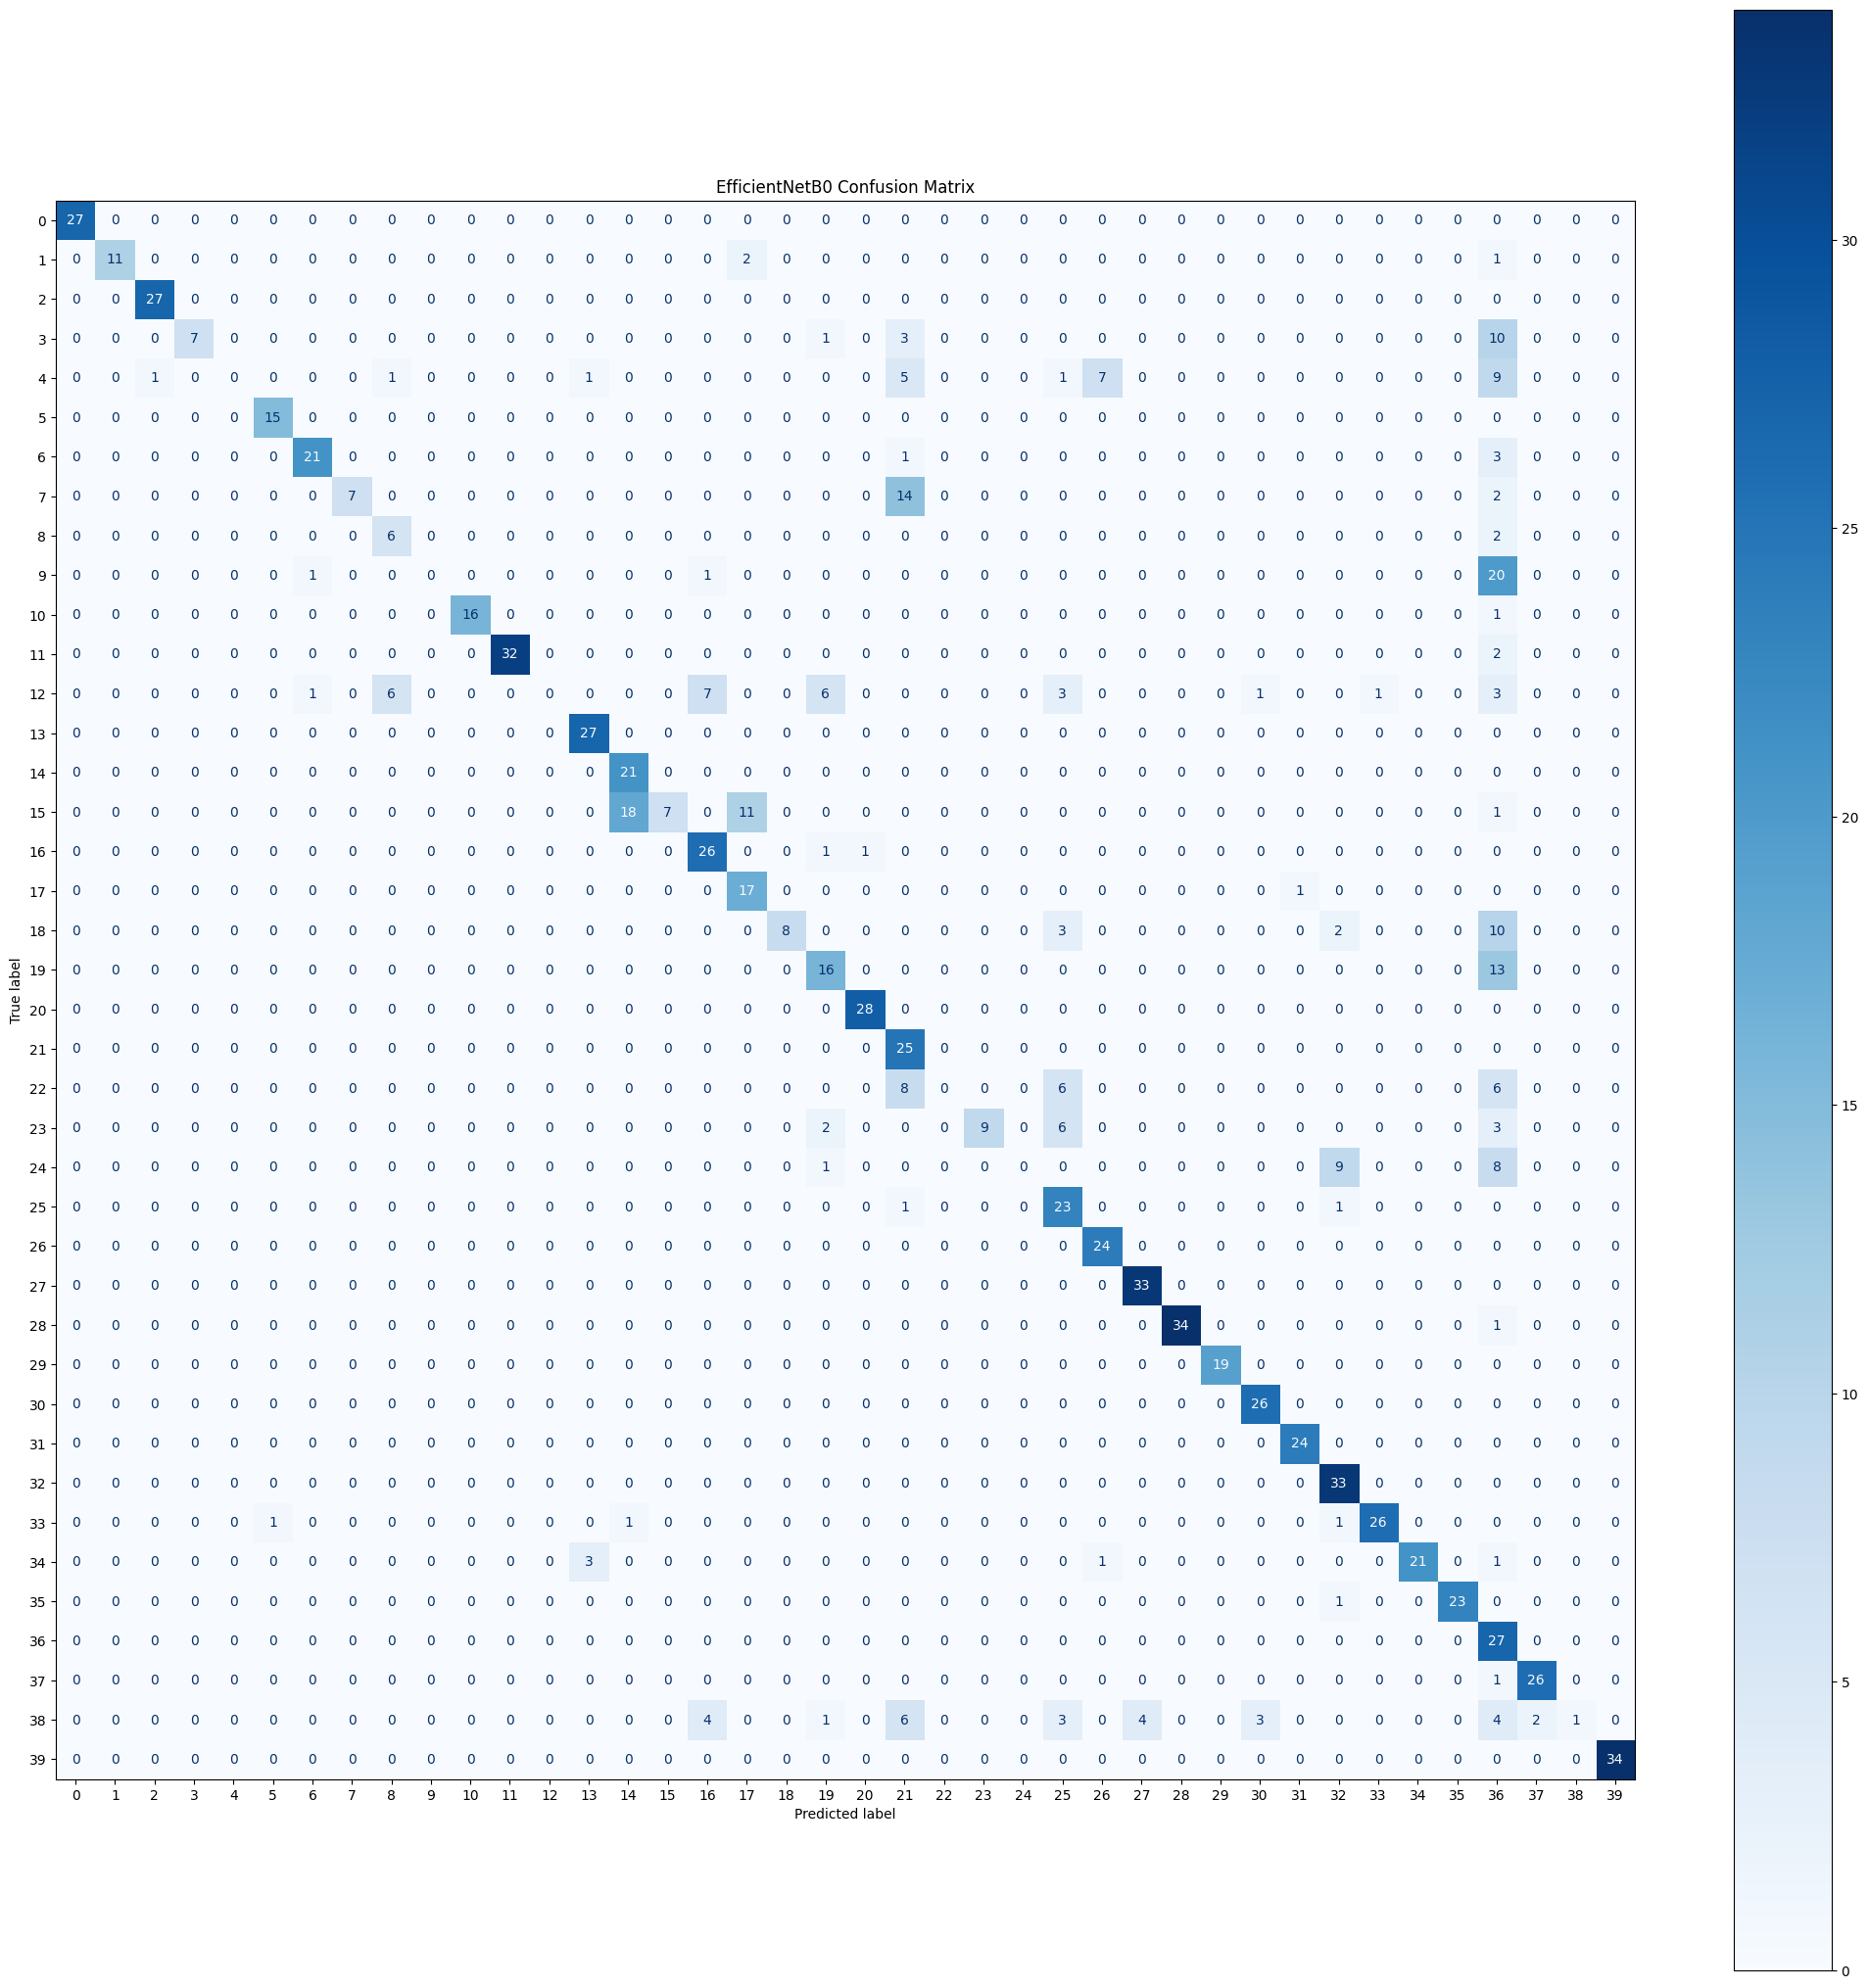

In [ ]:
efficientnetb1_40 = tf.keras.models.load_model('/content/efficientnetb1_40.keras')

y_prediction = efficientnetb1_40.predict(validation_dataset)
y_prediction = np.argmax(y_prediction, axis = 1)

# Extract the true labels from your validation_dataset
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)

fig, ax = plt.subplots(figsize=(26,26))
ax.set(xlabel='Predicted', ylabel='Actual', title='EfficientNetB1 Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_true, y_prediction, ax=ax, cmap=plt.cm.Blues)

In [ ]:
print("EfficientNetB0 Classificaton Report")
print(classification_report(y_true, y_prediction))

EfficientNetB0 Classificaton Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      0.79      0.88        14
           2       0.96      1.00      0.98        27
           3       1.00      0.33      0.50        21
           4       0.00      0.00      0.00        25
           5       0.94      1.00      0.97        15
           6       0.91      0.84      0.87        25
           7       1.00      0.30      0.47        23
           8       0.46      0.75      0.57         8
           9       0.00      0.00      0.00        22
          10       1.00      0.94      0.97        17
          11       1.00      0.94      0.97        34
          12       0.00      0.00      0.00        28
          13       0.87      1.00      0.93        27
          14       0.53      1.00      0.69        21
          15       1.00      0.19      0.32        37
          16       0.68      0.93      0.79  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Accuracy Score: ", accuracy_score(y_true, y_prediction))
print("Precision Score: ", precision_score(y_true, y_prediction, average='micro'))
print("Recall Score: ", recall_score(y_true, y_prediction, average='micro'))
print("F1 Score: ", f1_score(y_true, y_prediction, average='micro'))

Accuracy Score:  0.7313883299798792
Precision Score:  0.7313883299798792
Recall Score:  0.7313883299798792
F1 Score:  0.7313883299798793
